In [24]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense


# Import Dataset

In [7]:
index_col_names=['unit_id','time_cycle']
operat_set_col_names=['oper_set{}'.format(i) for i in range(1,4)]
sensor_measure_col_names=['sm_{}'.format(i) for i in range(1,22)]
all_col=index_col_names+operat_set_col_names+sensor_measure_col_names
print(all_col)

['unit_id', 'time_cycle', 'oper_set1', 'oper_set2', 'oper_set3', 'sm_1', 'sm_2', 'sm_3', 'sm_4', 'sm_5', 'sm_6', 'sm_7', 'sm_8', 'sm_9', 'sm_10', 'sm_11', 'sm_12', 'sm_13', 'sm_14', 'sm_15', 'sm_16', 'sm_17', 'sm_18', 'sm_19', 'sm_20', 'sm_21']


In [12]:
train_df=pd.read_csv('train_FD001.txt',delim_whitespace=True,names=all_col)
train_df.head()

,unit_id,time_cycle,oper_set1,oper_set2,oper_set3,sm_1,sm_2,sm_3,sm_4,sm_5,...,sm_12,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


# Feature Selection

we notice:
* oper_set3,sensor 1, 5,10,16,18,19 are constant functions.
* We remove these features that doesnot change with time

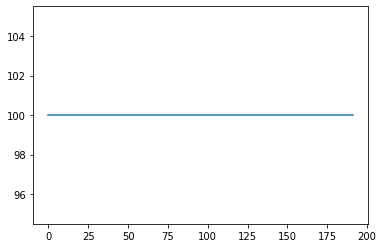

In [13]:
temp_df=train_df[train_df['unit_id']==1]
plt.plot(temp_df['sm_19'])

In [14]:
cols_drop=['oper_set3','sm_1','sm_5','sm_10','sm_14','sm_16','sm_18','sm_19','time_cycle','oper_set1','oper_set2']
train_df = train_df.drop(cols_drop, axis = 1)


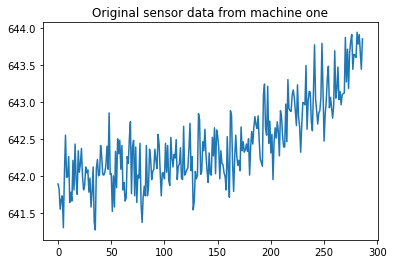

In [15]:
signal1=train_df[train_df['unit_id']==2]['sm_2'].values
plt.plot(signal1)
plt.title('Original sensor data from machine one')
plt.show()

## Undersampling

We have temparature sensor data for 300 days we are down sampling by averaging  weekly data 

In [16]:
machine_1=train_df[train_df['unit_id']==2]['sm_2'].reset_index().drop('index',axis=1)
machine_1['day']=np.arange(1,len(machine_1)+1)
machine_1['week']=(machine_1['day']//7)+1

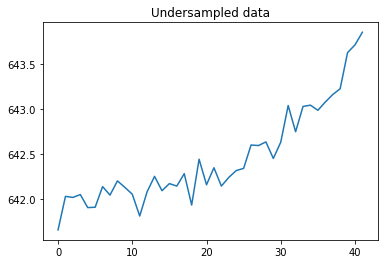

In [17]:
signal2=machine_1.groupby('week')['sm_2'].mean().values
plt.plot(signal2)
plt.title('Undersampled data')
plt.show()

In [25]:
def split_sequence(sequence, n_steps):
 X = []
 y = []
 for i in range(len(sequence)):
 # find the end of this pattern
  end_ix = i + n_steps
 # check if we are beyond the sequence
  if end_ix > len(sequence)-1:
    break
 # gather input and output parts of the pattern
  seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
  X.append(seq_x)
  y.append(seq_y)
 return np.array(X), np.array(y)

In [35]:
# choose a number of time steps
n_steps = 4
# split into samples
X, y = split_sequence(signal1, n_steps)
X_test,y_test=split_sequence(signal2, n_steps)

In [36]:
n_features = 1
X_train= X.reshape((X.shape[0], X.shape[1], n_features))
X_test=X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X_train, y, epochs=200, verbose=0)

In [37]:
yhat = model.predict(X, verbose=0)

In [38]:
y_undersample=model.predict(X_test, verbose=0)

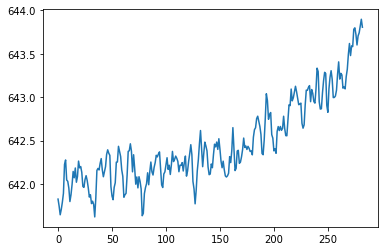

In [40]:
plt.plot(yhat)

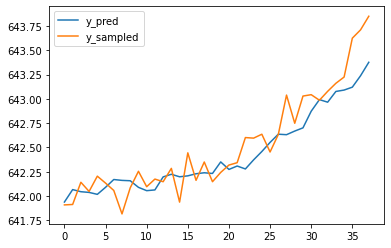

In [44]:
plt.plot(y_undersample)
plt.plot(y_test)
plt.legend(['y_pred','y_sampled'])
plt.show()

In [45]:
import numpy as np
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

distance, path = fastdtw(y_undersample, y_test, dist=euclidean)
print(distance)

3.8230622209817966


1) Lower value of cost function indicates the sampled distribution matches with the outpur predicted by a model fitted on whole timeseries.